# Plot joint deterministic inversion for shear modulus structure variations and fault slip as a function of rigidity parametrization

This notebook plots the results of several joint adjoint-based deterministic inversions by changing the shear modulus parametrization. 


In [1]:
# Import libraries
import dolfin as dl
import ufl
import math
import numpy as np
import pandas as pd
# Import libraries for plotting
from cmcrameri import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.tri as tri
from matplotlib.patches import Polygon
import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif', size=16)
rc('legend', fontsize=16)
TINY_SIZE = 14
SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

import sys, os
#sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "...") )
import hippylib as hp
# Load TV regularization class, observation operator, and IO .xdmf
from pointwiseStateObs import PointwiseStateObservation
from TVprior_Joint import *
from FunctionsIO import FunctionsIO

# Define folders directory 
meshpath = "../mesh/"
savepath = "./results_Joint_expression_mu_nu/"
os.system("mkdir " + savepath)
# Size domain
xmin = -700.; xmax = 400.; ymin = -500.; ymax = 0.
# Degree 
k = 2
# Define sep
sep = "\n"+"#"*80+"\n"


In [3]:
# Define function to plot the results
def plot_results(mesh, Vh, xf, yf, mu_true, m_mu, s_true, m_s, levels_m):
    # Convert solution for plotting
    triang = tri.Triangulation(*mesh.coordinates().reshape((-1, 2)).T, triangles=mesh.cells())
    mu_m_true = mu_true.compute_vertex_values(mesh)
    mu_m = m_mu.compute_vertex_values(mesh)

    # Plot figure    
    fig = plt.figure(figsize=(14,9))
    x_text, y_text = -180, -120 #50, -30
    props1 = dict(boxstyle='round', facecolor=cmap_1(0.99), edgecolor=cmap_1(0.99), alpha=1.)

    ax = plt.gca()
    ax.set_aspect('equal')
    ax.plot([lef, rig], [0.0, 0.0], 'k', linewidth=1.0)
    CS = ax.tricontourf(triang, (mu_m_true-np.mean(mu_m_true))/GPa2Pa, levels=levels_m, cmap=cmap_1, extend='both')
    #pl = dl.plot(dl.Function(Vh[hp.STATE].sub(1), u), cmap=cmap_2, zorder=3)
    ax.plot(targets[:,0], targets[:,1]+2.5, marker="^", linestyle='None',           
            markersize=12, markerfacecolor="grey", markeredgecolor="black", zorder=1)
    ax.plot(xf, yf, color="black")
    ax.set_xlim((lef, rig))
    ax.set_ylim((bot, 10.0))
    ax.text(0.957, 0.975, r'\textbf{(a)}', transform=ax.transAxes, fontsize=16,
                            verticalalignment='top', bbox=props)
    ax.text(0.85, 0.85, r"true $\mathbf{m}_{\mu}$", transform=ax.transAxes, fontsize=SMALL_SIZE,
                            verticalalignment='top', bbox=props1)

    # Make a new Axes instance [left, bottom, width, height]
    axins = ax.inset_axes([-0.1, -0.5, 1, 1.1])
    axins.set_aspect('equal')
    axins.tricontourf(triang, (mu_m-np.mean(mu_m))/GPa2Pa, levels=levels_m, cmap=cmap_1, extend='both')
    axins.add_patch(Polygon(xy_triangle, facecolor="None", edgecolor="black", linestyle="--"))
    axins.plot(xf, yf, color="black")
    axins.tick_params(axis='both', which='major')
    axins.set_xlim((lef, rig))
    axins.set_ylim((bot, topp))
    axins.set_ylabel("Depth [km]")
    axins.set_xlabel("Length [km]")
    axins.text(-0.085, -0.36, r'\textbf{(b)}', transform=ax.transAxes, fontsize=16,
                            verticalalignment='top', bbox=props) # (x,y)=(0.855,0.497) for top right
    axins.text(0.7, 0.4, r"recovered $\mathbf{m}_{\mu}$", transform=ax.transAxes, fontsize=SMALL_SIZE,
                            verticalalignment='top')

    # Make a new Axes instance [left, bottom, width, height]
    nseg_fault = len(yf)
    L = np.sqrt(yf[0]**2 + xf[0]**2) 
    width = np.linspace(0, L, nseg_fault) 

    # Define the inset figure size
    axins2 = ax.inset_axes([0.285, -0.29, 0.6, 0.45])
    axins2.plot(width, np.zeros(len(width)), '-.', color="grey")
    axins2.plot(width, s_true, color="gray", linestyle='solid', linewidth=2.,
               label=r'$\mathbf{m}^{\mathrm{true}}_{s}$')
    axins2.plot(width, m_s, color="black", linestyle='dashed', linewidth=2., 
                label=r'$\mathbf{m}^{\mathrm{est}}_{s}$')
    axins2.legend(loc='lower right')
    axins2.set_xlim(( width.min(), width.max() ))
    axins2.set_ylim(( -10.5, 1. ))
    axins2.set_xlabel("Distance along the fault [km]")
    axins2.set_ylabel("Fault slip [m]")
    axins2.tick_params(axis='both', which='both')
    axins2.text(0.3, -0.23, r'\textbf{(c)}', transform=ax.transAxes, fontsize=16,
                            verticalalignment='top', bbox=props)
    axins2.text(0.4, 0.1, r"recovered $\mathbf{m}_{s}$", transform=ax.transAxes, fontsize=SMALL_SIZE,
                            verticalalignment='top')

    # Make a new Axes instance [left, bottom, width, height]
    cbar_ax = plt.gcf().add_axes([0.925, 0.25, 0.0125, 0.5])
    cbar = plt.colorbar( CS, cax=cbar_ax, orientation="vertical",
                            format="%.0f", label=r'$\mathbf{m}^{\mathrm{est}}_{\mu}$')
    cbar.ax.set_title('[GPa]')

    plt.show()
    

In [4]:
# Define a function to retrieve the function spaces for plotting
def FunctionSpaces(mesh, k, verbose=True):
    # Define function spaces
    # Use VectorFunctionSpace if the unknown is a vector field.
    # Use FunctionSpace object for scalar fields.
    BDM = dl.VectorFunctionSpace(mesh, "BDM", k)    # stress (tensor field, since BDM is a vector field)
    DGv = dl.VectorFunctionSpace(mesh, "DG", k-1)   # displacement (vector field)
    DGr = dl.FunctionSpace(mesh, "DG", k-1)         # rotation (scalar field)
    ME_element = dl.MixedElement([BDM.ufl_element(), DGv.ufl_element(), DGr.ufl_element()])
    Vu = dl.FunctionSpace(mesh, ME_element)
    n = dl.FacetNormal(mesh)
    # Define mixed function spaces for the model parameters
    CG = dl.FunctionSpace(mesh, "CG", 1)
    CG_element = dl.MixedElement([CG.ufl_element(), CG.ufl_element()])
    Vm = dl.FunctionSpace(mesh, CG_element)
    # Combine the STATE, PARAMETER and ADJOINT function spaces
    Vh = [Vu, Vm, Vu]
    # Print the dofs of STATE, PARAMETER and ADJOINT variables
    ndofs = [ Vh[hp.STATE].dim(), Vh[hp.PARAMETER].dim(), Vh[hp.ADJOINT].dim() ]
    ndofs_state = [ Vu.sub(0).dim(), Vu.sub(1).dim(), Vu.sub(2).dim() ]
    if verbose:
        print( sep, "Set up the mesh and finite element spaces", sep )
        print( "Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(*ndofs) )
        print( "Number of STATE and ADJOINT dofs: STRESS={0}, DISPLACEMENT={1}, ROTATION={2}".format(*ndofs_state) )
    
    return Vh, CG
    

In [5]:
# Define the axes range
lef, rig, topp, bot = -200., 100., 0., -150.
GPa2Pa = 1e9

# Generate random surface observations
ntargets = 20
targets_x = np.linspace(-180., 0., ntargets) 
targets_y = (ymax-dl.DOLFIN_EPS)*np.ones(ntargets)
targets = np.zeros([ntargets, 2])
targets[:,0] = targets_x; targets[:,1] = targets_y

# Define colormaps and level for contourf
cmap_1 = plt.get_cmap("Oranges_r")
cmap_2 = plt.get_cmap("viridis", 21)
cmap_3 = plt.get_cmap("RdBu_r")
cmap_4 = plt.get_cmap("RdBu_r", 21)
levels_ux = np.linspace(-4., 4., 21)
levels_uy = np.linspace(-4., 4., 21)
levels_m = np.linspace(-5., 5., 21)
colors = [ cmap_1(0.3), cmap_1(0.6), cmap_1(0.9) ]

# Define the triangular perimeter of the anomaly
xy_triangle = np.array([ [-160.0,-5.0], [-30.0,-5.0], [-95.0, -55.0] ]) 

# For labels of subplots (a,b,c,d)
props = dict(boxstyle='round', lw=0.25, facecolor='ivory', alpha=0.95)

# Define the shear modulus background structure and the anomaly
mu_true_anomaly, mu_true_background = 26.49, 39.52


## Import mesh

In [6]:
# Import mesh
path = "../Mesh/"
name = "Mesh_CurvedFault_Triangle_PaperII" 
mesh = dl.Mesh(path + name + '.xml')
xmin = -700.; xmax = 400.; ymin = -500.; ymax = 0.
# Extract dimension of the mesh
dim = mesh.topology().dim()
# Define normal component to boundaries
n = dl.FacetNormal(mesh)
# Define boundaries
boundaries = dl.MeshFunction("size_t", mesh, path + name + '_facet_region.xml')
subdomains = dl.MeshFunction("size_t", mesh, path + name + '_physical_region.xml')
top = 1
left = 2
bottom = 3
right = 4
fault = 5
blockleft = 7
blockright = 8
triangle = 9
triangle_surface = 10
ds = dl.Measure('ds')(domain=mesh, subdomain_data=boundaries)
dS = dl.Measure('dS')(domain=mesh, subdomain_data=boundaries)

# Define function space
Vh, CG = FunctionSpaces(mesh, k, verbose=True)

# Fault
namefolder = "fault_33_5_tanh_m_Triangle/"
path = savepath + namefolder
filename = 'fault_geometry.txt'
fault = pd.read_csv(path + filename, delimiter=' ')
xf, yf = fault['xf'], fault['yf']



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=57681, PARAMETER=2492, ADJOINT=57681
Number of STATE and ADJOINT dofs: STRESS=36162, DISPLACEMENT=14346, ROTATION=7173


## Import results from joint inversions by chaging the shear modulus parametrization

In three of these tests, we invert for the argument of the hyperbolic tangent to determine the shear modulus field. For these tests, we utilize a mathematical expression of the form:
\begin{align}
\mu(m_\mu) = \frac{\mu_0}{\alpha} \big( \alpha + \tanh(m_\mu) \big),
\end{align}
where $\mu_0$ is a reference shear modulus (we choose 33 GPa), and $\alpha$ is chosen as 10, 5, and 2.5 to confine the shear modulus within a range that is 0.5, 1, and 2 times the true range, respectively. 

In the last test, we invert for the argument of the exponential function, that is, $\mu(m_\mu) = \exp(m_\mu)$, to ensure the shear modulus remains positive. Our objective is to compare whether reliable estimates of both fault slip and subduction zone structure can be achieved regardless of the choice of $\mu(m_\mu)$. 


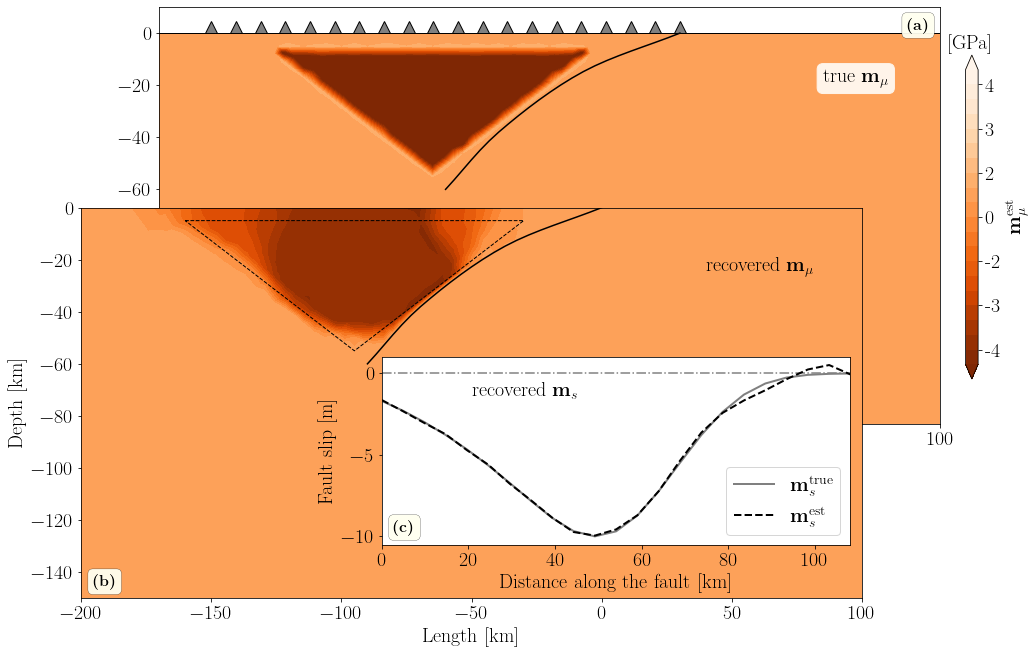

In [7]:
# alpha = 10
expression_33_10 = '_33_10_tanh_m'

# Load results to HDF5
namefolder = "fault" + str(expression_33_10) + "_Triangle/"
path = savepath + namefolder

# Parameters
filename = 'm_mu'
function_names = ['true', 'inferred']
all_funs = FunctionsIO.read(mesh.mpi_comm(), path + filename, CG, function_names)
mu_true_33_10 = all_funs[0]
m_mu_33_10 = all_funs[1]

# Slip
filename = 'm_s.txt'
slip_33_10 = pd.read_csv(path + filename, delimiter=' ')
s_true_33_10, m_s_33_10 = slip_33_10['true'], slip_33_10['cal']

# Observed data
filename = 'data.txt'
data_33_10 = pd.read_csv(path + filename, delimiter=' ')

# Plot the solution
plot_results(mesh, Vh, xf, yf, mu_true_33_10, m_mu_33_10, s_true_33_10, m_s_33_10, levels_m)


27.280192393359563 37.77724198691094


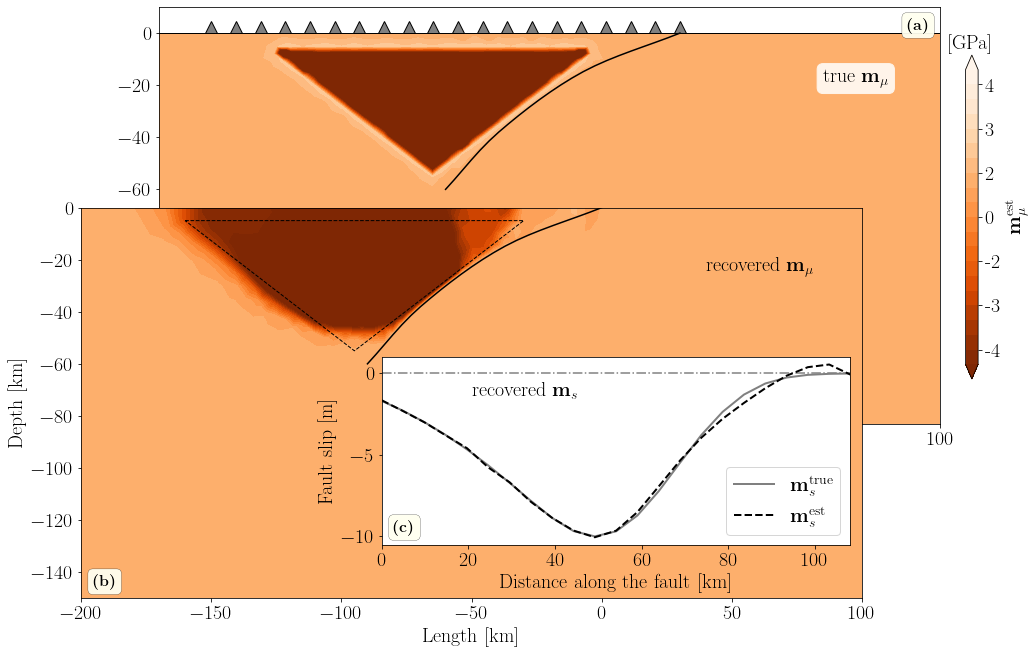

In [8]:
# alpha = 5
expression_33_5 = '_33_5_tanh_m'

# Load results to HDF5
namefolder = "fault" + str(expression_33_5) + "_Triangle/"
path = savepath + namefolder

# Parameters
filename = 'm_mu'
function_names = ['true', 'inferred']
all_funs = FunctionsIO.read(mesh.mpi_comm(), path + filename, CG, function_names)
mu_true_33_5 = all_funs[0]
m_mu_33_5 = all_funs[1]

# Slip
filename = 'm_s.txt'
slip_33_5 = pd.read_csv(path + filename, delimiter=' ')
s_true_33_5, m_s_33_5 = slip_33_5['true'], slip_33_5['cal']

# Observed data
filename = 'data.txt'
data_33_5 = pd.read_csv(path + filename, delimiter=' ')

# Plot the solution
print( min(m_mu_33_5.vector()[:]/GPa2Pa), max(m_mu_33_5.vector()[:]/GPa2Pa) )
plot_results(mesh, Vh, xf, yf, mu_true_33_5, m_mu_33_5, s_true_33_5, m_s_33_5, levels_m)


21.23266952711057 40.6078266221992


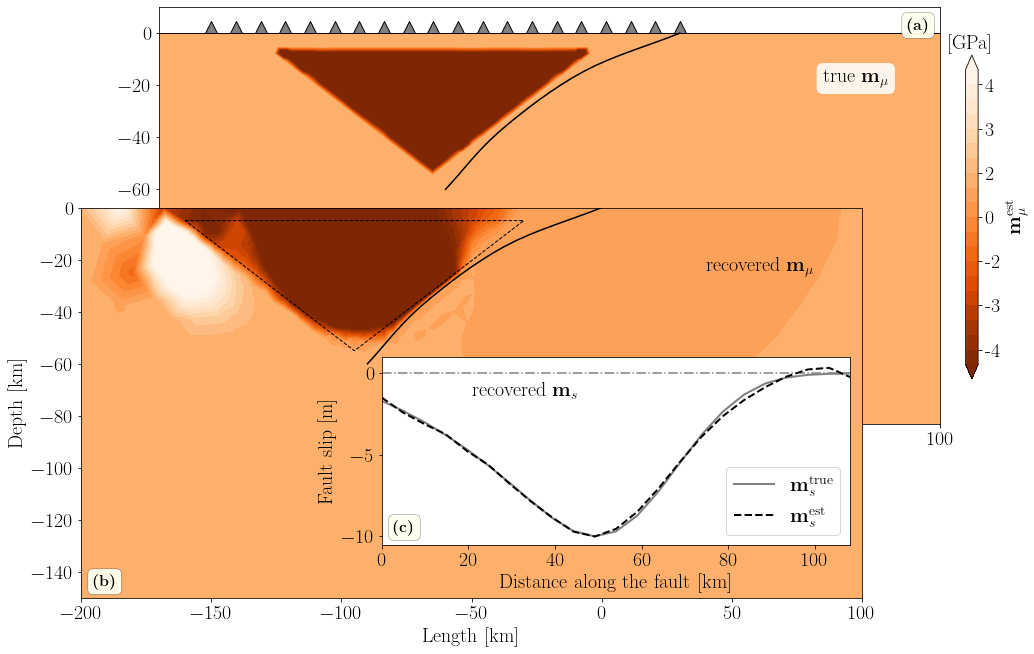

In [9]:
# alpha = 2.5
expression_33_25 = '_33_25_tanh_m'

# Load results to HDF5
namefolder = "fault" + str(expression_33_25) + "_Triangle/"
path = savepath + namefolder

# Parameters
filename = 'm_mu'
function_names = ['true', 'inferred']
all_funs = FunctionsIO.read(mesh.mpi_comm(), path + filename, CG, function_names)
mu_true_33_25 = all_funs[0]
m_mu_33_25 = all_funs[1]

# Slip
filename = 'm_s.txt'
slip_33_25 = pd.read_csv(path + filename, delimiter=' ')
s_true_33_25, m_s_33_25 = slip_33_25['true'], slip_33_25['cal']

# Observed data
filename = 'data.txt'
data_33_25 = pd.read_csv(path + filename, delimiter=' ')

# Plot the solution
print( min(m_mu_33_25.vector()[:]/GPa2Pa), max(m_mu_33_25.vector()[:]/GPa2Pa) )
plot_results(mesh, Vh, xf, yf, mu_true_33_25, m_mu_33_25, s_true_33_25, m_s_33_25, levels_m)


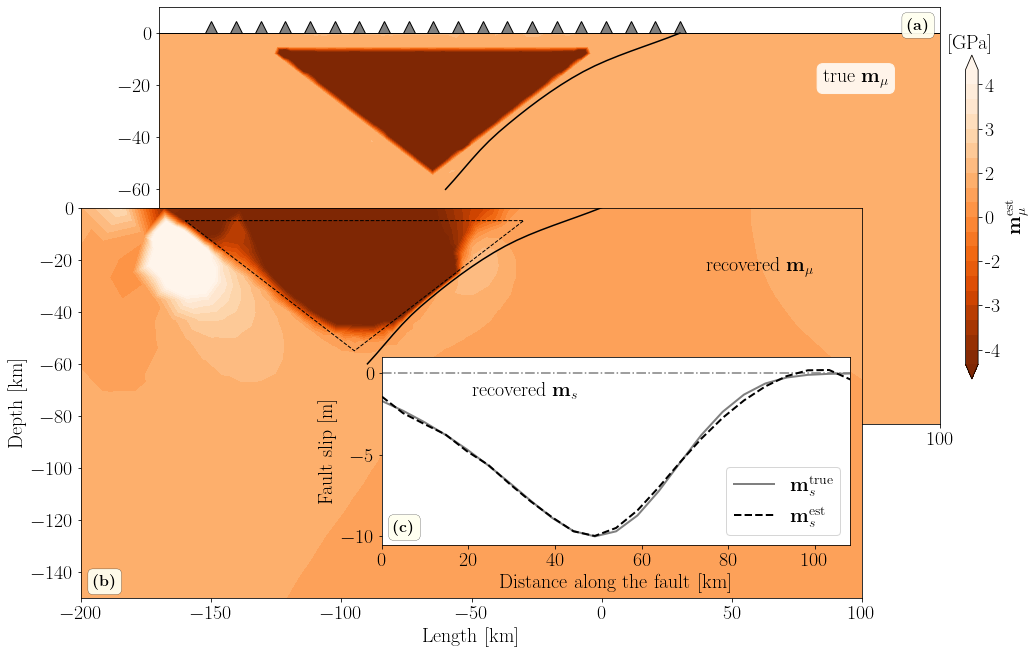

In [10]:
# exponential parameterization to ensure positivity
expression_exp = '_exp_m'

# Load results to HDF5
namefolder = "fault" + str(expression_exp) + "_Triangle/"
path = savepath + namefolder

# Parameters
filename = 'm_mu'
function_names = ['true', 'inferred']
all_funs = FunctionsIO.read(mesh.mpi_comm(), path + filename, CG, function_names)
mu_true_exp = all_funs[0]
m_mu_exp = all_funs[1]

# Slip
filename = 'm_s.txt'
slip_exp = pd.read_csv(path + filename, delimiter=' ')
s_true_exp, m_s_exp = slip_exp['true'], slip_exp['cal']

# Observed data
filename = 'data.txt'
data_exp = pd.read_csv(path + filename, delimiter=' ')

# Plot the solution
plot_results(mesh, Vh, xf, yf, mu_true_exp, m_mu_exp, s_true_exp, m_s_exp, levels_m)


In [11]:
# Combine the results in arrays for plotting
ms_mu_true = np.array([ mu_true_33_10, mu_true_33_5, mu_true_33_25, mu_true_exp ])  

ms_mu = np.array([ m_mu_33_10, m_mu_33_5, m_mu_33_25, m_mu_exp ]) 

ms_s = np.array([ m_s_33_10, m_s_33_5, m_s_33_25, m_s_exp ])

texts = np.array([ r"$\Delta\mu(\mathbf{m}_{\mu}) = \frac{1}{2}\Delta \mu^{\mathrm{true}}$",
                   r"$\Delta\mu(\mathbf{m}_{\mu}) = \Delta \mu^{\mathrm{true}}$", 
                   r"$\Delta\mu(\mathbf{m}_{\mu}) = 2\Delta \mu^{\mathrm{true}}$",
                   r"$\mu(\mathbf{m}_{\mu}) = \exp(\mathbf{m}_{\mu})$" ])

s_true = s_true_exp.copy()


## Plot results comparison

In [12]:
# Write a function to plot the inset figures
def plot_inset(m_mu, levels_m, text, location, X, Y, letter, if_ticks_left=False, if_label_left=False, if_ticks_bottom=False, if_label_bottom=False):
    
    # Convert solution for plotting
    triang = tri.Triangulation(*mesh.coordinates().reshape((-1, 2)).T, triangles=mesh.cells())
    mu_m = m_mu.compute_vertex_values(mesh)

    # Make a new Axes instance [left, bottom, width, height]
    axins = ax.inset_axes(location)
    axins.set_aspect('equal')
    axins.plot([lef, rig], [0.0, 0.0], 'k', linewidth=1.0, zorder=4)
    if if_label_bottom == False: 
        axins.plot(targets[:,0], targets[:,1]+3.5, marker="^", linestyle='None',
                   markersize=8, markerfacecolor="grey", markeredgecolor="black", zorder=2)

    CS = axins.tricontourf(triang, (mu_m-np.mean(mu_m))/GPa2Pa, levels=levels_m, cmap=cmap_1, extend='both')
    axins.add_patch(Polygon(xy_triangle, facecolor="None", edgecolor="black", linestyle="--"))
    axins.plot(xf, yf, color="black")
    axins.set_xlim((lef, rig))
    if if_label_bottom:
        axins.set_ylim((bot, topp))
        axins.text(X+0.4475, Y+0.11, letter, transform=ax.transAxes, fontsize=18,
                        verticalalignment='top', bbox=props) 
        axins.text(X+0.05, Y+0.175, text, transform=ax.transAxes, fontsize=20,
                        verticalalignment='top')
    
    else:
        axins.set_ylim((bot, topp+10.))
        axins.text(X+0.4475, Y+0.09, letter, transform=ax.transAxes, fontsize=18,
                        verticalalignment='top', bbox=props)
        axins.text(X+0.05, Y+0.175, text, transform=ax.transAxes, fontsize=20,
                        verticalalignment='top')
    
    
    axins.tick_params(axis='x', direction='out', labelsize=14)
    axins.tick_params(axis='y', direction='out', labelsize=14)
    axins.set_xticks([-150, -100, -50, 0., 50.])
    axins.set_yticks([0, -50, -100])
    
    # Decide if plot labels inset
    axins.tick_params(color='k', labelcolor='k',  
                        left=True, 
                        labelleft=if_label_left)
    if if_label_left:
        axins.set_ylabel('Depth [km]', fontsize=16)
        
    
    axins.tick_params(color='k', labelcolor='k',
                          labelbottom=if_ticks_bottom) 
    if if_label_bottom:
        axins.set_xlabel('Length [km]', fontsize=16)
        
    return CS


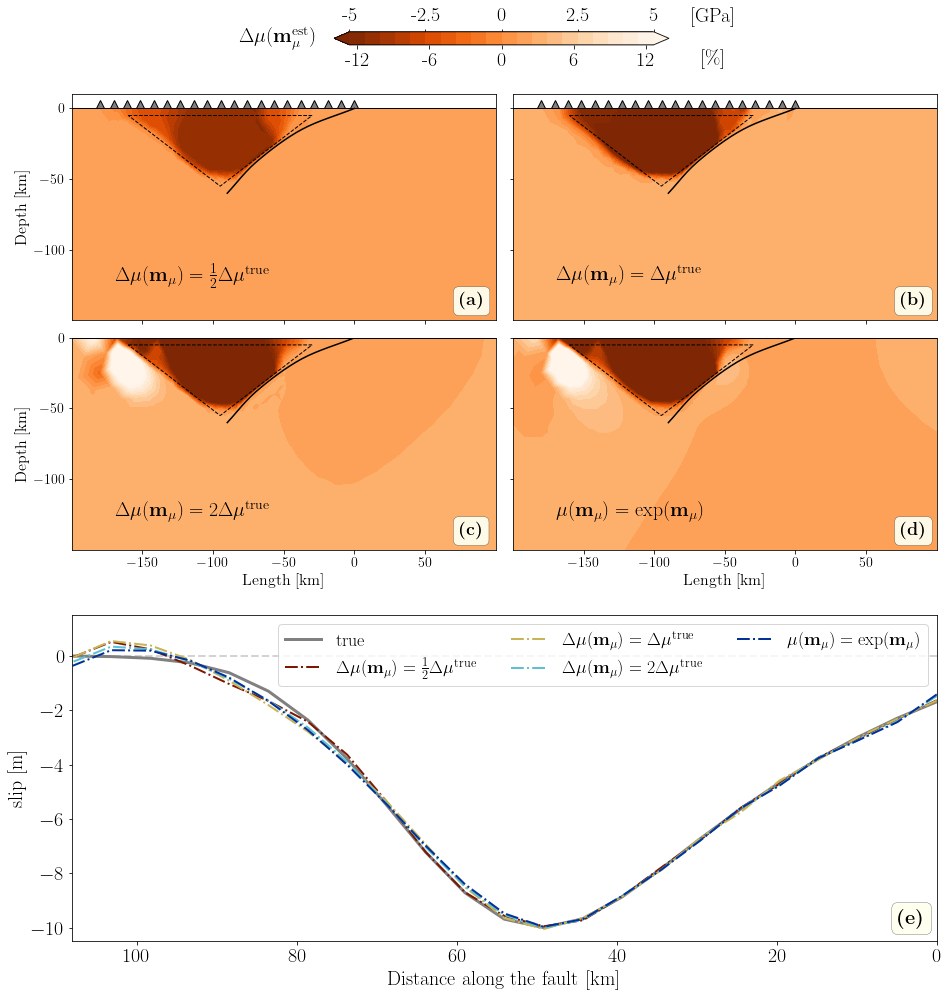

In [23]:
# Plot them together
nseg_fault = len(yf)
Leng = np.sqrt(yf[0]**2 + xf[0]**2) 
width = np.linspace(0, Leng, nseg_fault) 
# Choose colors
colors = cm.roma(np.linspace(0., 1., 4)) 
linestyles = ['solid', 'dashed', 'dashdot']
lww = 2.0

choices = np.arange(0, 4)
L, W = 0.49, 0.7
XX = [0, 0.51]
YY = [1.9, 1.175]

X = [ XX[0], XX[1], XX[0], XX[1] ]
Y = [ YY[0], YY[0], YY[1], YY[1] ]

letters = [ r'\textbf{(a)}', r'\textbf{(b)}', r'\textbf{(c)}', r'\textbf{(d)}', r'\textbf{(e)}' ]


# Plot
fig, ax = plt.subplots(1, 1, figsize=(15.5,6))

ax.plot(width, s_true-s_true, color='lightgray', ls=linestyles[1], lw=lww)
ax.plot(width, s_true, color='gray', ls=linestyles[0], lw=lww+1, 
        label=r'true')
ax.text(0.955, 0.1, letters[-1], transform=ax.transAxes, fontsize=SMALL_SIZE,
                        verticalalignment='top', bbox=props)     

# Plot the insets all around this central plot (create a function which plots)
for i, j in enumerate(choices):
    
    ax.plot(width, ms_s[i], color=colors[i], ls=linestyles[2], lw=lww, 
        label=texts[i])
    
    location = [X[i], Y[i], L, W]
    if j == 0:
        CS = plot_inset(ms_mu[j], levels_m, texts[j], [X[i], Y[i], L, W], X[i], Y[i], letters[i], 
                    if_ticks_left=True, if_label_left=True, if_ticks_bottom=False, if_label_bottom=False)
    elif j == 1:
        CS = plot_inset(ms_mu[j], levels_m, texts[j], [X[i], Y[i], L, W], X[i], Y[i], letters[i], 
                    if_ticks_left=False, if_label_left=False, if_ticks_bottom=False, if_label_bottom=False)
    elif j == 2:
        CS = plot_inset(ms_mu[j], levels_m, texts[j], [X[i], Y[i], 0.49, W], X[i], Y[i], letters[i], 
                    if_ticks_left=True, if_label_left=True, if_ticks_bottom=True, if_label_bottom=True)
    elif j == 3:
        CS = plot_inset(ms_mu[j], levels_m, texts[j], [X[i], Y[i], 0.49, W], X[i], Y[i], letters[i], 
                    if_ticks_left=False, if_label_left=False, if_ticks_bottom=True, if_label_bottom=True)
        
ax.legend(loc='upper right', ncol=3, fontsize=18)
ax.set_xlim((0, Leng))
ax.set_ylim((-10.5, 1.5))
ax.set_xlabel(r'Distance along the fault [km]')
ax.set_ylabel(r'slip [m]')
ax.invert_xaxis()


# Make a new Axes instance [left, bottom, width, height]
cbar_ax = plt.gcf().add_axes([0.36, 2.2, 0.3, 0.03])
cbar = plt.colorbar( CS, cax=cbar_ax, orientation="horizontal", 
                    ticks=[-5., -2.5, 0., 2.5, 5.],
                    format="%.1f")
cbar.ax.set_xticklabels( ['-5', '-2.5', '0', '2.5', '5'] )
cbar.set_label(r'[GPa]', labelpad=-15, x=1.2)
plt.gcf().text(0.275, 2.205, r'$\Delta\mu(\mathbf{m}^{\mathrm{est}}_{\mu})$', fontsize=SMALL_SIZE)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
# Put second colorbar
cbar_ax2 = plt.gcf().add_axes([0.36, 2.2, 0.3, 0.03])
# Scale colorbar
scaling = (5/mu_true_background)*100
scaling_ticks_ = np.array([-12, -6, 0., 6, 12])    
scaling_ticks = (5*scaling_ticks_/scaling).tolist()    
cbar2 = plt.colorbar(CS, cax=cbar_ax2, orientation="horizontal",
                     ticks=scaling_ticks)
cbar2.ax.set_xticklabels( ['-12', '-6', '0', '6', '12'] )
cbar2.set_label(r'[\%]', labelpad=-20, x=1.2)

plt.show()
